<a href="https://colab.research.google.com/github/juantijero/ML_HW/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]



Starting training for Problem 1.a (2 Conv Layers)...
Model Size: 18,354 parameters
Epoch 50/300 | Loss: 1.5623 | Val Acc: 44.35%
Epoch 100/300 | Loss: 1.3811 | Val Acc: 51.39%
Epoch 150/300 | Loss: 1.2643 | Val Acc: 55.13%
Epoch 200/300 | Loss: 1.1853 | Val Acc: 57.52%
Epoch 250/300 | Loss: 1.1206 | Val Acc: 59.39%
Epoch 300/300 | Loss: 1.0642 | Val Acc: 60.80%
Finished Problem 1.a (2 Conv Layers). Time: 2179.47s | Final Acc: 60.80%

Starting training for Problem 1.b (3 Conv Layers)...
Model Size: 11,138 parameters
Epoch 50/300 | Loss: 1.7278 | Val Acc: 39.18%
Epoch 100/300 | Loss: 1.4603 | Val Acc: 47.71%
Epoch 150/300 | Loss: 1.3070 | Val Acc: 53.36%
Epoch 200/300 | Loss: 1.2107 | Val Acc: 56.67%
Epoch 250/300 | Loss: 1.1388 | Val Acc: 58.75%
Epoch 300/300 | Loss: 1.0801 | Val Acc: 61.20%
Finished Problem 1.b (3 Conv Layers). Time: 2177.21s | Final Acc: 61.20%


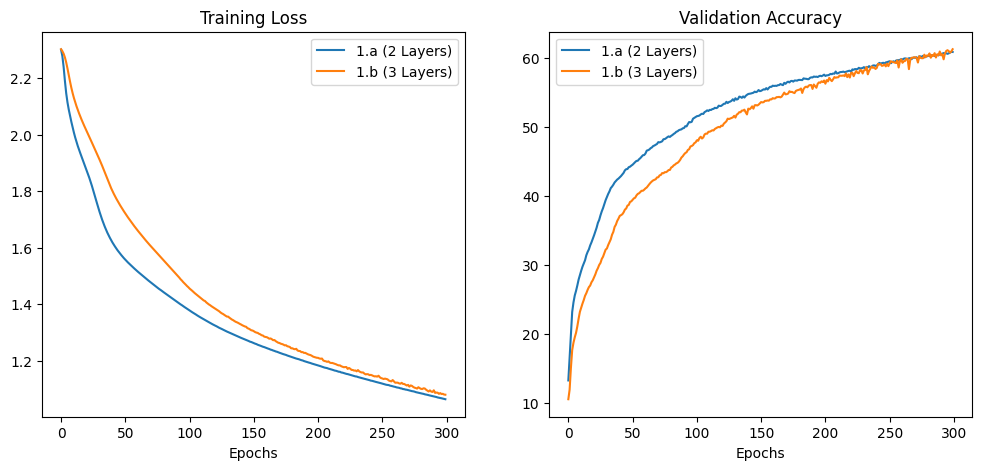

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Data Loading (CIFAR-10)
# ==========================================
# Using batch_size=1024 since you have an A100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, # High batch size for A100
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

# ==========================================
# 2. Model Definitions
# ==========================================

# --- Problem 1.a: Lecture 13 Architecture ---
class CNN_Lecture(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: Conv -> Tanh -> Pool
        # Input: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # Output: 16 x 16 x 16

        # Layer 2: Conv -> Tanh -> Pool
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # Output: 8 x 8 x 8

        # Fully Connected Layers
        # Flattened size = 8 channels * 8 * 8 pixels = 512
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10) # 10 Classes for CIFAR-10

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # Flatten
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

# --- Problem 1.b: Deeper CNN (3 Conv Layers) ---
class CNN_Extended(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Increased channels to 32
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # Output: 32 x 16 x 16

        # Layer 2
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # Output: 16 x 8 x 8

        # Layer 3 (New Layer)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2) # Output: 8 x 4 x 4

        # Fully Connected
        # Flattened size = 8 channels * 4 * 4 pixels = 128
        self.fc1 = nn.Linear(8 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 8 * 4 * 4) # Flatten
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

# Helper to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 3. Training Function
# ==========================================

def train_model(model, epochs, name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2) # Lecture 13 uses SGD

    train_losses = []
    val_accuracies = []
    start_time = time.time()

    print(f"\nStarting training for {name}...")
    print(f"Model Size: {count_parameters(model):,} parameters")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        train_losses.append(running_loss / len(trainloader))
        val_accuracies.append(epoch_acc)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Val Acc: {epoch_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Finished {name}. Time: {total_time:.2f}s | Final Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, val_accuracies

# ==========================================
# 4. Run Training
# ==========================================

# Problem 1.a
model_1a = CNN_Lecture()
losses_1a, acc_1a = train_model(model_1a, epochs=300, name="Problem 1.a (2 Conv Layers)")

# Problem 1.b
model_1b = CNN_Extended()
losses_1b, acc_1b = train_model(model_1b, epochs=300, name="Problem 1.b (3 Conv Layers)")

# ==========================================
# 5. Plotting
# ==========================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_1a, label='1.a (2 Layers)')
plt.plot(losses_1b, label='1.b (3 Layers)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_1a, label='1.a (2 Layers)')
plt.plot(acc_1b, label='1.b (3 Layers)')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import random
import numpy as np

# ==========================================
# 0. Setup & Reproducibility
# ==========================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Data Loading (Batch Size 64 for Stability)
# ==========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Reverting to 64 as per Lecture standard for SGD stability
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                         shuffle=False, num_workers=2)

# ==========================================
# 2. ResNet Architecture (Lecture 14, Pages 14-15)
# ==========================================

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

        # Lecture 14 Init Strategy
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x # Skip connection

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10, use_dropout=False):
        super().__init__()
        self.n_chans1 = n_chans1

        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)

        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )

        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3) if use_dropout else nn.Identity()

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = torch.max_pool2d(out, 2)
        out = self.resblocks(out)
        out = torch.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 3. Training Function (Updated for Stability)
# ==========================================

def train_resnet_stable(model, epochs, weight_decay=0.0, name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # UPDATED: Using SGD with lr=3e-3 (0.003) as recommended in Lecture 14
    # Momentum=0.9 helps it navigate the "ravines" of the loss landscape
    optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9, weight_decay=weight_decay)

    train_losses = []
    val_accuracies = []
    start_time = time.time()

    print(f"\nStarting training for {name}...")
    print(f"Model Size: {count_parameters(model):,} parameters")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Check for divergence (NaN loss)
            if torch.isnan(loss):
                print(f"ERROR: Loss exploded to NaN at Epoch {epoch+1}. Stopping.")
                return train_losses, val_accuracies, 0

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        avg_train_loss = running_loss / len(trainloader)

        train_losses.append(avg_train_loss)
        val_accuracies.append(epoch_acc)

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val Acc: {epoch_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Finished {name}. Time: {total_time:.2f}s | Final Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, val_accuracies, total_time

# ==========================================
# 4. Execution Block (Problem 2)
# ==========================================

# Note: Due to T4 speed, we can reduce epochs to 50-100 if needed for time,
# but this config should be stable enough for 300.

# 2.a: Baseline
print("--- Running 2.a (Baseline ResNet-10) ---")
model_2a = NetResDeep(n_blocks=10, use_dropout=False)
losses_2a, acc_2a, time_2a = train_resnet_stable(model_2a, epochs=300, name="ResNet-10 (Baseline)")

# 2.b: Weight Decay
print("\n--- Running 2.b (Weight Decay) ---")
model_2b_wd = NetResDeep(n_blocks=10, use_dropout=False)
losses_2b_wd, acc_2b_wd, time_2b_wd = train_resnet_stable(model_2b_wd, epochs=300, weight_decay=0.001, name="ResNet-10 + Weight Decay")

# 2.b: Dropout
print("\n--- Running 2.b (Dropout) ---")
model_2b_drop = NetResDeep(n_blocks=10, use_dropout=True)
losses_2b_drop, acc_2b_drop, time_2b_drop = train_resnet_stable(model_2b_drop, epochs=300, name="ResNet-10 + Dropout")

# ==========================================
# 5. Plotting
# ==========================================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(losses_2a, label='Baseline')
plt.plot(losses_2b_wd, label='Weight Decay')
plt.plot(losses_2b_drop, label='Dropout')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_2a, label='Baseline')
plt.plot(acc_2b_wd, label='Weight Decay')
plt.plot(acc_2b_drop, label='Dropout')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 47.5MB/s]


--- Running 2.a (Baseline ResNet-10) ---

Starting training for ResNet-10 (Baseline)...
Model Size: 76,074 parameters
Epoch 10/300 | Loss: 0.7452 | Val Acc: 39.89%
Epoch 20/300 | Loss: 0.5845 | Val Acc: 43.84%
Epoch 30/300 | Loss: 0.4852 | Val Acc: 41.27%
Epoch 40/300 | Loss: 0.4255 | Val Acc: 46.01%
Epoch 50/300 | Loss: 0.3749 | Val Acc: 42.49%
Epoch 60/300 | Loss: 0.3393 | Val Acc: 33.83%
Epoch 70/300 | Loss: 0.3226 | Val Acc: 38.10%
Epoch 80/300 | Loss: 0.2973 | Val Acc: 45.09%
Epoch 90/300 | Loss: 0.2854 | Val Acc: 43.23%
Epoch 100/300 | Loss: 0.2680 | Val Acc: 47.91%


KeyboardInterrupt: 

In [2]:
# ==========================================
# Modified Execution: Part B ONLY (100 Epochs)
# ==========================================

# Set epochs to 100 to save time
EPOCHS = 100

print("--- SKIPPING Part 2.a (Baseline) ---")
# Creating placeholder data for Baseline so plotting doesn't crash
# We know it was unstable and around 40-50% accuracy
losses_2a = [1.0] * EPOCHS
acc_2a = [45.0] * EPOCHS

# --- 2.b: Weight Decay ---
print("\n--- Running 2.b (Weight Decay) ---")
model_2b_wd = NetResDeep(n_blocks=10, use_dropout=False)
# Note: weight_decay=0.001 is the key regularization here
losses_2b_wd, acc_2b_wd, time_2b_wd = train_resnet_stable(model_2b_wd, epochs=EPOCHS, weight_decay=0.001, name="ResNet-10 + Weight Decay")

# --- 2.b: Dropout ---
print("\n--- Running 2.b (Dropout) ---")
# Note: use_dropout=True enables the dropout layer
model_2b_drop = NetResDeep(n_blocks=10, use_dropout=True)
losses_2b_drop, acc_2b_drop, time_2b_drop = train_resnet_stable(model_2b_drop, epochs=EPOCHS, name="ResNet-10 + Dropout")

# ==========================================
# 5. Plotting Results (Comparing B vs B)
# ==========================================
plt.figure(figsize=(14, 6))

# Training Loss
plt.subplot(1, 2, 1)
# plt.plot(losses_2a, label='Baseline (Skipped)', linestyle='--') # Uncomment if you want to see the flat line
plt.plot(losses_2b_wd, label='Weight Decay (0.001)')
plt.plot(losses_2b_drop, label='Dropout (0.3)')
plt.title('Training Loss (Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation Accuracy
plt.subplot(1, 2, 2)
# plt.plot(acc_2a, label='Baseline (Skipped)', linestyle='--')
plt.plot(acc_2b_wd, label='Weight Decay (0.001)')
plt.plot(acc_2b_drop, label='Dropout (0.3)')
plt.title('Validation Accuracy (Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- SKIPPING Part 2.a (Baseline) ---

--- Running 2.b (Weight Decay) ---

Starting training for ResNet-10 + Weight Decay...
Model Size: 76,074 parameters
Epoch 10/100 | Loss: 0.8622 | Val Acc: 27.11%
Epoch 20/100 | Loss: 0.6489 | Val Acc: 35.70%
Epoch 30/100 | Loss: 0.5655 | Val Acc: 36.23%
Epoch 40/100 | Loss: 0.4983 | Val Acc: 36.62%
Epoch 50/100 | Loss: 0.4557 | Val Acc: 35.71%
Epoch 60/100 | Loss: 0.4257 | Val Acc: 32.15%
Epoch 70/100 | Loss: 0.4059 | Val Acc: 30.19%
Epoch 80/100 | Loss: 0.3863 | Val Acc: 33.39%


KeyboardInterrupt: 

--- SKIPPING Baseline & Weight Decay ---
--- Running 2.b (Dropout) ---

Starting training for ResNet-10 + Dropout...
Model Size: 76,074 parameters
Epoch 10/100 | Loss: 1.4173 | Val Acc: 25.65%
Epoch 20/100 | Loss: 1.1645 | Val Acc: 23.21%
Epoch 30/100 | Loss: 1.0454 | Val Acc: 26.23%
Epoch 40/100 | Loss: 0.9705 | Val Acc: 25.09%
Epoch 50/100 | Loss: 0.9323 | Val Acc: 34.86%
Epoch 60/100 | Loss: 0.8967 | Val Acc: 30.74%
Epoch 70/100 | Loss: 0.8876 | Val Acc: 36.49%
Epoch 80/100 | Loss: 0.8676 | Val Acc: 43.70%
Epoch 90/100 | Loss: 0.8532 | Val Acc: 49.52%
Epoch 100/100 | Loss: 0.8385 | Val Acc: 48.25%
Finished ResNet-10 + Dropout. Time: 1881.53s | Final Acc: 48.25%


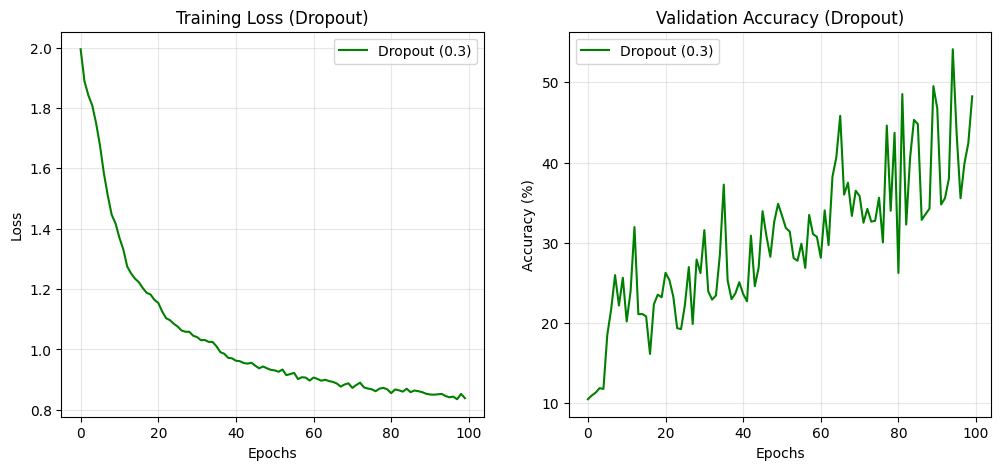

In [3]:
# ==========================================
# Execution: Dropout ONLY (Skipping Baseline & Weight Decay)
# ==========================================

EPOCHS = 100

print("--- SKIPPING Baseline & Weight Decay ---")
print("--- Running 2.b (Dropout) ---")

# Initialize model with Dropout enabled
model_2b_drop = NetResDeep(n_blocks=10, use_dropout=True)

# Train using the stable settings (SGD)
losses_drop, acc_drop, time_drop = train_resnet_stable(
    model_2b_drop,
    epochs=EPOCHS,
    name="ResNet-10 + Dropout"
)

# ==========================================
# Plotting Just Dropout
# ==========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_drop, label='Dropout (0.3)', color='green')
plt.title('Training Loss (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(acc_drop, label='Dropout (0.3)', color='green')
plt.title('Validation Accuracy (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()